# Experiments with Ratio Outcomes

*How to estimate and do inference in click-through rates, returns of investment and more.*

Some of the most common outcome metrics or **key performance indicators (KPI)** in the industry are **ratios**: click-through rates (clicks over views), returns on investment (revenue over cost), relative improvements (new outcome over old outcome), just to name few. If you want to investigate the causal effect of a treatment of interest (new product, new feature, new interface, ...) on these outcomes, the gold standard are randomized control trials, a.k.a. **AB tests**. Randomly assigning the treatment to a subset of the population (users, patients, customers, ...) we ensure that, on average, the only difference in outcomes can be attributed to the treatment. However, when the outcome is a ratio of two metrics, AB tests present some additional problems.

The first problem is that the estimator is biased. Even though one can estimate numerator and denominator without bias, the estimate of the ration will be biased. Second, computing a conference interval is not trivial and often people resort to bootstrapping, which is computationally intensive. However, a simple solutions exists.

In this post we are going to see how to solve both problems. First, we are going to apply a bias correction to the estimate. Second, we are going to explore a very powerful tool for inference with complex metrics: the **delta method**. While the algebra can be intense, the result is simple: we can compute the confidence interval for our ratio estimator using a simple linear regression. 

## Clicks and Ads

To better illustrate the concepts, we are going to use a toy example throughout the article. Support we were a **food delivery** company that is testing a new UI for their landing page. The object of interest is the **incremental click-through ratio (CTR)**: does the number of clicks per view increase?

$$
\text{ctr} = \frac{\text{incremental number of clicks}}{\text{incremental number of views}} = \frac{\mathbb E [\Delta C]}{\mathbb E [\Delta V]}
$$

Differently from usual AB tests or randomized experiments, we are not interested in a single difference, but in the **ratio** of two differences: the effect on page views and the effect on clicks. We will still use a **randomized control trial** or **AB test** to estimate the incremental CTR: randomly assign users to either a treatment control condition. The treated users will see the new landing page, while the control users will see the old one. Randomization ensures that we can estimate the impact of the new landing page on either clicks or views by comparing users in the treatment and control group: the difference in their average is an unbiased estimator of the average treatment effect. However, things are more complicated for their ratio.

I import the data generating process `dgp_loyalty()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).  To include not only code but also data and tables, I use [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *
from src.dgp import dgp_clicks

In [2]:
dgp = dgp_clicks(outcome_vars=['views', 'clicks'],
                 assignment_var='new_ui',
                 n=10_000,
                 p=0.5)
df = dgp.generate_data()
df.head()

,new_ui,views,clicks
0,1,11.0,0.0
1,1,3.0,0.0
2,1,5.0,2.0
3,1,2.0,0.0
4,0,1.0,1.0


The data contains information on the number of page `views` and `clicks` for a set of $10.000$ users over a period of a month. We also have information on the `treatment`: the new landing page.  As it often happens with business metrics, both distributions of views and clicks are very **skewed**.

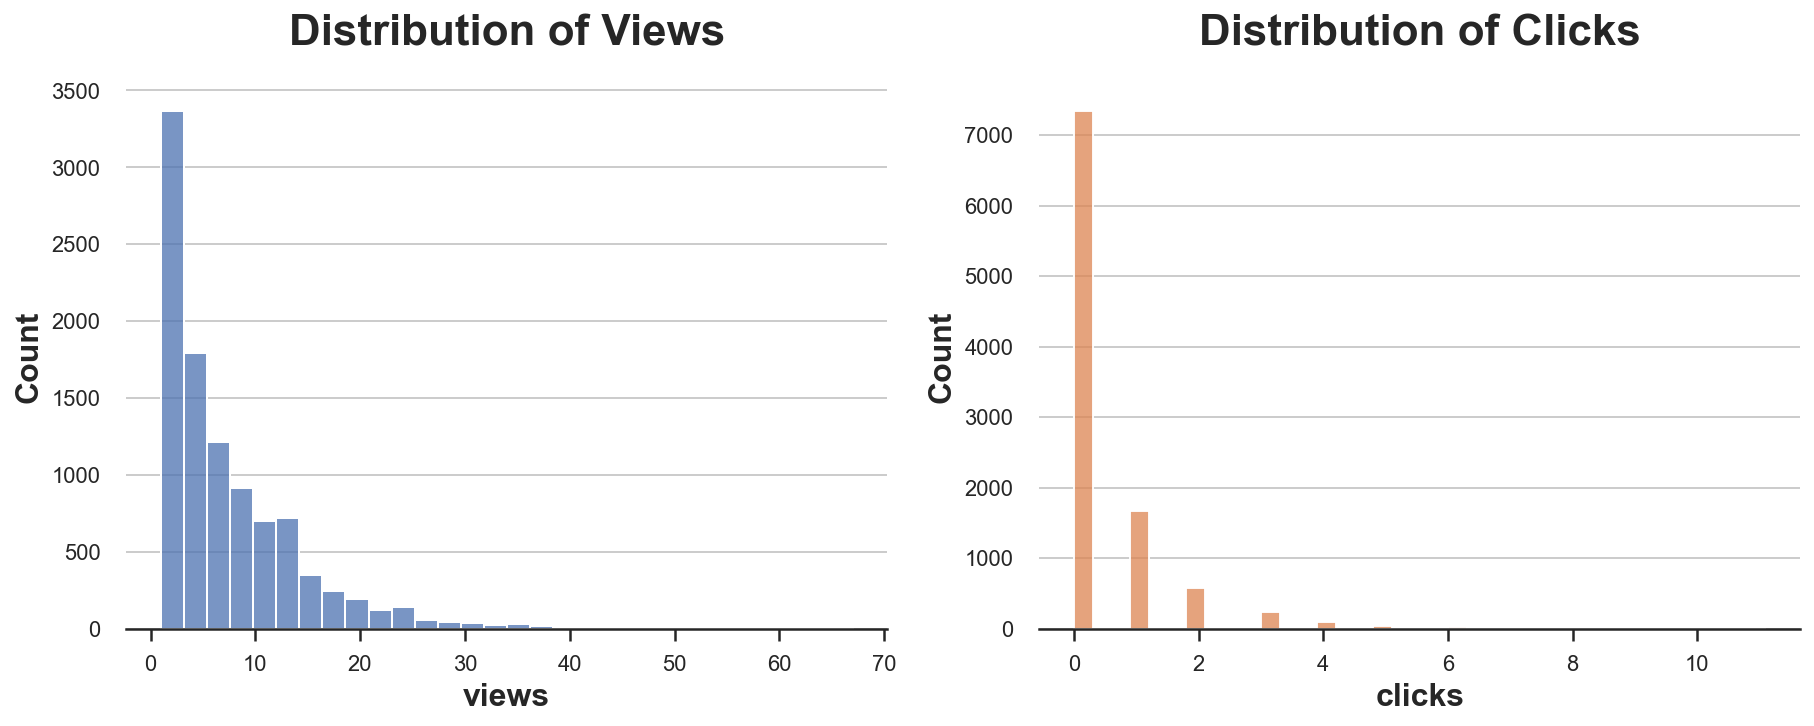

In [3]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df.views, ax=ax1, color='C0', bins=30).set(title='Distribution of Views')
sns.histplot(df.clicks, ax=ax2, color='C1', binwidth=.3).set(title='Distribution of Clicks');

We can compute the difference-in-means estimate by regressing the outcome on the treatment indicator.

In [4]:
smf.ols('views ~ new_ui', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.2164,0.092,67.597,0.000,6.036,6.397
new_ui,2.4971,0.131,19.077,0.000,2.241,2.754


The number of views has increased by ???. What about clicks?

In [5]:
smf.ols('clicks ~ new_ui', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1074,0.012,8.761,0.000,0.083,0.131
new_ui,0.6734,0.017,38.582,0.000,0.639,0.708


Also the number of clicks has increased, by ???. What about their ratio?

We can estimate the incremental click-through rate as the ratio of the two previous estimates: the difference between the average clicks in the treatment minus control group, over the difference between the average views in the treatment minus control group.

$$
\hat{\text{ctr}} = \frac{\mathbb E_n [\Delta C]}{\mathbb E_n [\Delta V]}
$$

Note a subtle but crucial difference with respect to the previous formula: we have replaced the [expected values](https://en.wikipedia.org/wiki/Expected_value) $\mathbb E$ with the empirical expectation operators $\mathbb E_n$, also known as the [sample average](https://en.wikipedia.org/wiki/Arithmetic_mean). The difference in notation is minimal, but the conceptual difference is huge. The first, $\mathbb E$, is a **theoretical** concept, while the second $\mathbb E_n$, while the second one is **empirical**: it is a number that depends on the actual data. I personally like the notation since it highlights the close link between the two concepts (the second is the empirical counterpart of the first), while also making it clear that the second crucially depends on the sample size $n$.

In [6]:
def estimate_ctr(df):
    clicks = df.loc[df.new_ui==1, "clicks"].mean() - df.loc[df.new_ui==0, "clicks"].mean()
    views = df.loc[df.new_ui==1, "views"].mean() - df.loc[df.new_ui==0, "views"].mean()
    return clicks / views

In [7]:
estimate_ctr(df)

0.26966010738038276

The estimate is $0.2697$: for each additional page view, there is a 27% that the user clicks on the page. How much should we trust this number? Is it significantly different form zero, or it is just driven by noise?

To answer this question, we would like to compute a [**confidence interval**](https://en.wikipedia.org/wiki/Confidence_interval). How do we compute a a confidence interval for a ratio metric? The first step is to compute the standard deviation of the estimator. 

One method that is always available is the [**bootstrap**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): resample the data with replacement multiple and times and use the distribution of the estimates over samples to compute the standard deviation of the estimator.

Let's try it in our case. I compute the standard deviation over $10.000$ bootstrapped samples, using the function `pd.DataFrame().sample()` to sample with replacement.

In [8]:
np.std([estimate_ctr(df.sample(frac=1, replace=True, random_state=i)) for i in range(10_000)])

0.016079944440980785

The bootstrap estimate of the standard deviation is equal to $0.0160$. How good is it?

Since we fully control the data generating process, we can simulate the "true" distribution of the estimator. We do that for $10.000$ simulations and we compute the resulting standard deviation of the estimator.

In [9]:
np.std(dgp.evaluate_f_redrawing_outcomes(estimate_ctr, 10_000))

0.015475230927575944

The "true" variance of the estimator seems to be lower, around $0.0154$. The issue might be related to the fact that the bootstrap is particularly volatile with skewed distributions. One solution is the [**bayesian boostrap**](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148) that I have covered in a separate post.

We are now going to explore another *extremely* powerful alternative, the [**delta method**](https://en.wikipedia.org/wiki/Delta_method). The delta method generally allows us to do inference on functions of random variable, therefore it's applications are broader than ratios. However, I don't think there is an easy way to approach the delta method, so the next section is going to be algebra-intense. If you want, you can skip it and go straight to the last section.

## The Delta Method

What is the **Delta Method**? In short, it is an incredibly powerful **asymptotic inference** method for functions of random variables, that exploits Taylor expansions. In short, the Delta Method requires four ingredients

- One or more [random variables](https://en.wikipedia.org/wiki/Random_variable)
- A function
- [The Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
- [Taylor expansions](https://en.wikipedia.org/wiki/Taylor_series)

I will assume some basic knowledge of all four concepts. Suppose we had a set of realizations $X_1$, ..., $X_n$ of a random variable that satisfy the requirements for the Central Limit Theorem (CLT): independence, identically distributed with expected value $\mu$ and finite variance $\sigma^2$. Under these conditions, the CLT tells us that the distribution of the sample average $\mathbb E_n[X]$ converges in distribution to a normal distribution, or more precisely

$$
\sqrt{n} \ \frac{ \mathbb E_n[X] - \mu}{\sigma} \ \overset{D}{\to} \ N(0, 1)
$$

What does the equation mean? It reads "the normalized sample average, scaled by a factor $\sqrt{n}$, converges in distribution to a standard normal distribution, i.e. it is approximately Gaussian for a sufficiently large sample.

Now, suppose we were interested in a **function** of the sample average $f\big(\mathbb E_n[X]\big)$ instead of the sample average $\mathbb E_n[X]$. Note that this is different from the average of the function $\mathbb E_n\big[f(X)\big]$. The Delta Method tells us what the function of the sample average $f(\bar X)$ converges in distribution to. 

$$
\sqrt{n} \ \frac{ f\big(\mathbb E_n[X]\big) - f(\mu)}{\sigma} \ \overset{D}{\to} \ N \big(0, f'(\mu)^2 \big)
$$

, where $f'(\mu)^2$ is the derivative of the function $f$, evaluated at $\mu$.

The result directly follows from the Taylor approximation of $ff\big(\mathbb E_n[X]\big)$

$$
f\big(\mathbb E_n[X]\big) = f(\mu) + f'(\mu) (\mathbb E_n[X] - \mu) + O \big\lbrace (\mathbb E_n[X] - \mu)^2 \big\rbrace
$$

Importantly, asymptotically, the last term disappears and the linear approximation holds exactly!

How is this connected to the ratio estimator? We need a bit more math and to switch from a single dimension to two dimensions in order to understand that. In our case, we have a bivariate function that input two random variables, $\Delta C$ and $\Delta V$ and returns their ratio. In the case of a multivariate function $f$, the asymptotic variance of the estimator is given by

$$
\text{AVar} \big( \hat{\text{ctr}} \big) = \nabla \hat{\text{ctr}}' \Sigma_n \nabla \hat{\text{ctr}}
$$

where, $\nabla$ indicates the [gradient](https://en.wikipedia.org/wiki/Gradient) of the function, i.e. the vector of directional derivatives, and $\Sigma_n$ is the empirical variance-covariance matrix of $X$. In our case, they correspond to

$$
\nabla \hat{\text{ctr}}
= 
\begin{bmatrix} 
\frac{1}{\mathbb E_n [\Delta V]} \\ - \frac{\mathbb E_n [\Delta C]}{\mathbb E_n [\Delta V]^2}
\end{bmatrix}
$$

and

$$
\Sigma_n = 
\begin{bmatrix}
\text{Var}_n (\Delta C) & \text{Cov}_n (\Delta C, \Delta V) \\
\text{Cov}_n (\Delta C, \Delta V) & \text{Var}_n (\Delta V) \\
\end{bmatrix}
$$

, where the subscripts $n$ indicate the empirical counterparts, as for the expected value. With a little matrix algebra, we get the formula of the asymptotic variance of the ratio estimator.

$$
\begin{align*}
\text{AVar} \big( \hat{\text{ctr}} \big) &= \frac{1}{\mathbb E_n[\Delta V]^2} \text{Var}_n(\Delta C) - 2 \frac{\mathbb E_n[\Delta C]}{\mathbb E_n[\Delta V]^3} \text{Cov}_n(\Delta V, \Delta C) + \frac{\mathbb E_n[\Delta C]^2}{\mathbb E_n[\Delta V]^4} \text{Var}_n(\Delta V)
\end{align*}
$$

Importantly, we can rewrite the variance noting that the estimator is given by $\hat{\text{ctr}} = \frac{\mathbb E_n[\Delta C]}{\mathbb E_n[\Delta V]}$

$$
\begin{align*}
\text{AVar} \big( \hat{\text{ctr}} \big) = \frac{1}{\mathbb E_n[\Delta V]^2} \text{Var}_n \Big( \Delta C - \hat{\text{ctr}} \Delta V \Big) = \frac{1}{\mathbb E_n[\Delta V]^2} \text{Var}_n \Big( \Delta \big( C - \hat{\text{ctr}} V \big) \Big)
\end{align*}
$$

The last expression is very interesting because it suggests that we can estimate the standard deviation of our estimator by **linear regression**.

## Inference with Linear Regression

Did you skip the previous section? No problem!

After some algebra, we concluded that we can estimate the variance of our estimator as

$$
\begin{align*}
\text{AVar} \big( \hat{\text{ctr}} \big) = \frac{1}{\mathbb E_n[\Delta V]^2} \text{Var}_n \big( \Delta \tilde C \big)
\end{align*}
$$

, where $\tilde C = C - \hat{\text{ctr}} V$. This expression might seem obscure at first, but it is incredibly useful. In fact, it gives us (1) an intuitive **interpretation** of the variance of the estimator and (2) a **practical** way to estimate it.

Interpretation first! How should we read the above expression? We can estimate the variance of the empirical estimator as the variance of a difference-in-means estimator, for a new variable $\tilde C$ that we can easily compute from the data. We just need to scale it down by $\mathbb E_n[\Delta V]^2$. Therefore, the variance is decreasing in the causal effect of the treatment on the views $V$. 

Now, let's use the equation above to estimate the variance of the click-through rate estimator, in **three steps**.

1. The term $\mathbb E_n[\Delta V]$ is the difference in average views between the treatment and control group.

In [10]:
e_delta_v = df.views[df.new_ui==1].mean() - df.views[df.new_ui==0].mean()

2. The variable $\tilde C$ is the number of clicks $C$ minus the number of views $V$, scaled by the estimated click-through rate $\hat{\text{ctr}}$.

In [11]:
df['clicks_tilde'] = df['clicks'] - estimate_ctr(df) * df['views'] 

3. The variance of the treatment-control difference $\Delta \tilde C$ can be directly computed by linear regression, as in randomized controlled trials for difference-in-means estimators (for more details see Agrist and Pischke, 2008).

In [12]:
sd_err = smf.ols('clicks_tilde ~ new_ui', df).fit().bse[1]

We now have all the ingredients to compute the standard deviation of the estimator..

In [13]:
sd_err / np.abs(e_delta_v)

0.01566505344911916

We have estimated the variance of the ratio estimator with a simple linear regression! The estimated value $0.0156$ is very close to the "true" value of $0.0152$ and significantly faster than the bootstrap (around 1000 times faster on my machine).

## Conclusion

In this article, we have explore a very common causal inference problem in the inference: assessing the effects of a treatment on an outcome metric. The additional complications come from the fact that we are studying not one, but two causal effects, intertwined. The effects are both first- and second-order. First, the estimator is biased. Second, computing the variance of the estimator is not trivial.

We have explored an incredibly powerful method to do inference for complex random variables: the **delta method**. In the particular case of ratio metrics, the delta method delivers a very insightful and practical functional form for the asymptotic variance of the estimator that can be estimated with a simple linear regression.

### References

[1] A. Deng, U. Knoblich, J. Lu, [Applying the Delta Method in Metric Analytics: A Practical Guide with Novel Ideas](https://arxiv.org/pdf/1803.06336.pdf) (2018).  

[2] R. Budylin, A. Drutsa, I. Katsev, V. Tsoy, [Consistent Transformation of Ratio Metrics for Efficient Online Controlled Experiments](https://dl.acm.org/doi/abs/10.1145/3159652.3159699) (2018). *ACM*.

[3] J. Angrist, J. Pischke, [Mostly harmless econometrics: An empiricist's companion](https://www.mostlyharmlesseconometrics.com/) (2009). *Princeton university press*.

### Related Articles

- [The Bayesian Bootstrap](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/delta.ipynb